In [2]:
import timeit
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [ ]:
%%bash
make clean

## Run for each schedule chunk size

In [4]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

function run_experiment {
    make clean
    make VERSION=$1
    nthreads=1

    for ((sch = 1; sch <= 64; sch++)); do # Add a loop for schedule, chunk size from 1 to 64
        # Remember to remake the file after modifying it
        make clean
        make VERSION=$1
    
        # Modify the stencil2d-$1.x+orig file before running it
        sed -i "s/schedule(static)/schedule(guided, $sch)/g" stencil2d-$1.F90
            for nthreads in 1 2; do
            export OMP_NUM_THREADS=$nthreads
            ncores=$(( nthreads > 24 ? 24 : nthreads ))
                for ((i = 1; i <= 3; i++)); do
                    index=$((nthreads * 10 + i))
                    srun -n 12 -c $ncores ./stencil2d-$1.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024 | sed "s/data =/out[$index] =/g" >> 12$1_$sch.txt
                done
            done
    done
}

versions=("mpi_gui_2" ) # set schedule running version
for version in ${versions[@]}; do
    run_experiment $version
done

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_partitioner.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-mpi_gui_2.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o m_partitioner.o stencil2d-mpi_gui_2.o -o stencil2d-mpi_gui_2.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-mpi_gui_2.x' (lite-samples) ...OK


cp stencil2d-mpi_gui_2.x stencil2d.x
rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_partitioner.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-mpi_gui_2.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o m_partitioner.o stencil2d-mpi_gui_2.o -o stencil2d-mpi_gui_2.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-mpi_gui_2.x' (lite-samples) ...OK


cp stencil2d-mpi_gui_2.x stencil2d.x


srun: Cancelled pending job step with signal 2
srun: error: Unable to create step for job 48673139: Job/step already completing or completed


Error while terminating subprocess (pid=25745): 


srun: Job 48673139 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48673139


## Store running time of different schedule results

In [23]:
# adjustable constant
times = []
set_nthreads = 2
len_rep = 3 # length of repitition times
num_chunksize = 64

# Function to load data
def execute_code_and_extract_time(file_name, result_list):
    # Initialize out to a sufficient size.
    out = [None] * (set_nthreads * 10 + len_rep + 1)  # Adjust size as necessary.
    # Execute the code in the txt file.
    exec(open(file_name, "r").read())
    # Extract the time values into the result_list.
    result_list.extend([x[0][-1] for x in out if x is not None])


# Function of calculating mean and confidence interval
def calculate_confidence_interval(data, confidence_level=0.95):   
    """
     Calculate confidence intervals for data# def calculate_confidence_interval(data, confidence_level=0.95):

    
     parameter:
     data: one-dimensional array, the data to calculate the confidence interval
     confidence_level: confidence level, default is 0.95
    
     return value:
     mean: the mean of the data
     lower_bound: the lower bound of the confidence interval
     upper_bound: the upper bound of the confidence interval

    """
    
    n = len(data)
    mean = np.mean(data)
    standard_error = np.std(data, ddof=1) / np.sqrt(n - 1)
    t_value = stats.t.ppf((1 + confidence_level) / 2, df=n - 1)
    margin_of_error = t_value * standard_error
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error
    return mean, lower_bound, upper_bound

# Load data
sta_list = [ [] for _ in range(num_chunksize) ]
for i in range(1, num_chunksize + 1):
    execute_code_and_extract_time(f"12mpi_sta_{i}.txt", sta_list[i-1])
    
sta_2_list = [ [] for _ in range(num_chunksize) ]
for i in range(1, num_chunksize + 1):
    execute_code_and_extract_time(f"12mpi_sta_2_{i}.txt", sta_2_list[i-1])

dyn_list = [ [] for _ in range(num_chunksize) ]
for i in range(1, num_chunksize + 1):
    execute_code_and_extract_time(f"12mpi_dyn_{i}.txt", dyn_list[i-1])
    
dyn_2_list = [ [] for _ in range(num_chunksize) ]
for i in range(1, num_chunksize + 1):
    execute_code_and_extract_time(f"12mpi_dyn_2_{i}.txt", dyn_2_list[i-1])
    

gui_list = [ [] for _ in range(num_chunksize) ]
for i in range(1, num_chunksize + 1):
    execute_code_and_extract_time(f"12mpi_gui_{i}.txt", gui_list[i-1])
    
gui_2_list = [ [] for _ in range(num_chunksize) ]
for i in range(1, num_chunksize + 1):
    execute_code_and_extract_time(f"12mpi_gui_2_{i}.txt", gui_2_list[i-1])    


# Create an empty dictionary to store the results for different threads and chunk sizes
results_sta = {}
for i in range(1, set_nthreads+1):  
    mean = [None] * num_chunksize
    lower_bound = [None] * num_chunksize
    upper_bound = [None] * num_chunksize
    for j in range(1, num_chunksize + 1):
        # Calculate confidence interval using the custom function
        mean[j-1], lower_bound[j-1], upper_bound[j-1] = calculate_confidence_interval(sta_list[j-1][(len(sta_list[j-1])//set_nthreads)*(i-1):(len(sta_list[j-1])//set_nthreads)*i-1])

        # Store the results in the dictionary
        results_sta[i] = {
            "mean_t": mean,
            "lower_bound_t": lower_bound,
            "upper_bound_t": upper_bound
        }

results_sta_2 = {}
for i in range(1, set_nthreads+1):  
    mean = [None] * num_chunksize
    lower_bound = [None] * num_chunksize
    upper_bound = [None] * num_chunksize
    for j in range(1, num_chunksize + 1):
        # Calculate confidence interval using the custom function
        mean[j-1], lower_bound[j-1], upper_bound[j-1] = calculate_confidence_interval(sta_2_list[j-1][(len(sta_list[j-1])//set_nthreads)*(i-1):(len(sta_2_list[j-1])//set_nthreads)*i-1])

        # Store the results in the dictionary
        results_sta_2[i] = {
            "mean_t": mean,
            "lower_bound_t": lower_bound,
            "upper_bound_t": upper_bound
        }
        
        
results_dyn = {}
for i in range(1, set_nthreads+1):  
    mean = [None] * num_chunksize
    lower_bound = [None] * num_chunksize
    upper_bound = [None] * num_chunksize
    for j in range(1, num_chunksize + 1):
        # Calculate confidence interval using the custom function
        mean[j-1], lower_bound[j-1], upper_bound[j-1] = calculate_confidence_interval(dyn_list[j-1][(len(dyn_list[j-1])//set_nthreads)*(i-1):(len(dyn_list[j-1])//set_nthreads)*i-1])

        # Store the results in the dictionary
        results_dyn[i] = {
            "mean_t": mean,
            "lower_bound_t": lower_bound,
            "upper_bound_t": upper_bound
        }

results_dyn_2 = {}
for i in range(1, set_nthreads+1):  
    mean = [None] * num_chunksize
    lower_bound = [None] * num_chunksize
    upper_bound = [None] * num_chunksize
    for j in range(1, num_chunksize + 1):
        # Calculate confidence interval using the custom function
        mean[j-1], lower_bound[j-1], upper_bound[j-1] = calculate_confidence_interval(dyn_2_list[j-1][(len(dyn_list[j-1])//set_nthreads)*(i-1):(len(dyn_2_list[j-1])//set_nthreads)*i-1])

        # Store the results in the dictionary
        results_dyn_2[i] = {
            "mean_t": mean,
            "lower_bound_t": lower_bound,
            "upper_bound_t": upper_bound
        }
        
results_gui = {}
for i in range(1, set_nthreads+1):  
    mean = [None] * num_chunksize
    lower_bound = [None] * num_chunksize
    upper_bound = [None] * num_chunksize
    for j in range(1, num_chunksize + 1):
        # Calculate confidence interval using the custom function
        mean[j-1], lower_bound[j-1], upper_bound[j-1] = calculate_confidence_interval(gui_list[j-1][(len(gui_list[j-1])//set_nthreads)*(i-1):(len(gui_list[j-1])//set_nthreads)*i-1])

        # Store the results in the dictionary
        results_gui[i] = {
            "mean_t": mean,
            "lower_bound_t": lower_bound,
            "upper_bound_t": upper_bound
        }

results_gui_2 = {}
for i in range(1, set_nthreads+1):  
    mean = [None] * num_chunksize
    lower_bound = [None] * num_chunksize
    upper_bound = [None] * num_chunksize
    for j in range(1, num_chunksize + 1):
        # Calculate confidence interval using the custom function
        mean[j-1], lower_bound[j-1], upper_bound[j-1] = calculate_confidence_interval(gui_2_list[j-1][(len(gui_list[j-1])//set_nthreads)*(i-1):(len(gui_2_list[j-1])//set_nthreads)*i-1])

        # Store the results in the dictionary
        results_gui_2[i] = {
            "mean_t": mean,
            "lower_bound_t": lower_bound,
            "upper_bound_t": upper_bound
        }

Record the running time of each tuning.

## Comparison of different schedual results 

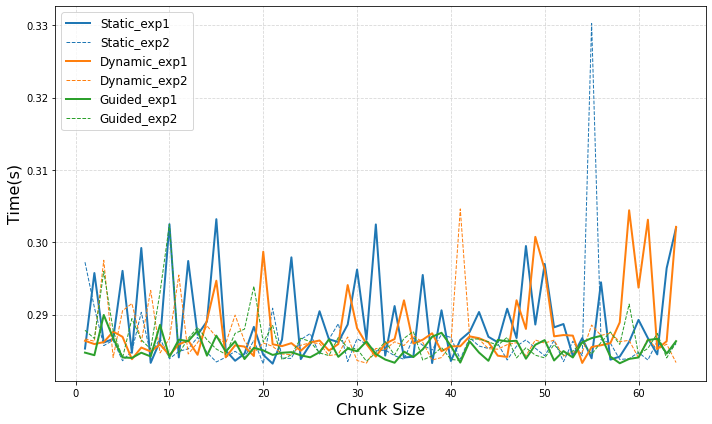

In [30]:
# X-axis values 
x_values = np.linspace(1, num_chunksize, num=num_chunksize)

# Plotting the line graph with academic-friendly colors and improved style
plt.figure(figsize=(10, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

plt.plot(x_values, results_sta[1]["mean_t"], label='Static_exp1', color=colors[0], linewidth=2)
plt.plot(x_values, results_sta_2[1]["mean_t"], label='Static_exp2', color=colors[0], linewidth=1, linestyle='--')
plt.plot(x_values, results_dyn[1]["mean_t"], label='Dynamic_exp1', color=colors[1], linewidth=2)
plt.plot(x_values, results_dyn_2[1]["mean_t"], label='Dynamic_exp2', color=colors[1], linewidth=1, linestyle='--')
plt.plot(x_values, results_gui[1]["mean_t"], label='Guided_exp1', color=colors[2], linewidth=2)
plt.plot(x_values, results_gui_2[1]["mean_t"], label='Guided_exp2', color=colors[2], linewidth=1, linestyle='--')
# plt.plot(x_values, results[2]["mean_t"], label='thr2_sta', color='#006400', linewidth=3, marker='o', markersize=8)

# # Adding the additional points at x=3
# plt.scatter(3, thr2_x3_dyn, color='#00008B', marker='o', s=100, label='thr2_x3_dyn')
# plt.scatter(3, thr2_x3_gui, color='#800080', marker='o', s=100, label='thr2_x3_gui')

# Adding labels and removing the title
plt.xlabel('Chunk Size', fontsize=16)
plt.ylabel('Time(s)', fontsize=16)
plt.legend(fontsize=12)

# Customize the grid
plt.grid(True, linestyle='--', alpha=0.5)

# Adjusting the plot layout
plt.tight_layout()

# Save the plot as a high-resolution image (optional)
# plt.savefig('academic_line_plot.png', dpi=300)

# Display the plot
plt.show()